In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score 

print("All necessary libraries loaded.")

All necessary libraries loaded.


In [ ]:
file_name = 'data.csv'
try:
    
    df = pd.read_csv(file_name, encoding='ISO-8859-1')
    print(f"'{file_name}' loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: File not found. Please ensure '{file_name}' is in the same folder as this notebook.")
    df = None

'data.csv' loaded successfully.


In [ ]:

if df is not None:
    print("\n--- DataFrame Head ---")
    print(df.head())

    print("\n--- DataFrame Info ---")
    df.info()


--- DataFrame Head ---
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------ 

In [ ]:

print(f"Initial number of rows: {len(df)}")


df.dropna(subset=['CustomerID'], inplace=True)
print(f"Rows after dropping missing CustomerID: {len(df)}")


df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['CustomerID'] = df['CustomerID'].astype(str)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

print(f"Final number of cleaned rows: {len(df)}")
print("\n--- Final Cleaned Info ---")
df.info()

Initial number of rows: 541909
Rows after dropping missing CustomerID: 406829
Final number of cleaned rows: 397884

--- Final Cleaned Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  object        
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.3+ MB


In [ ]:

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"Snapshot Date for Recency calculation: {snapshot_date}")


rfm_df = df.groupby('CustomerID').agg(
    
    Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    

    Frequency=('InvoiceNo', 'nunique'),
    
    
    Monetary=('TotalPrice', 'sum')
).reset_index()

print("\n--- RFM DataFrame Head (Initial Features) ---")
print(rfm_df.head())
print(f"Total number of customers ready for clustering: {len(rfm_df)}")

Snapshot Date for Recency calculation: 2011-12-10 12:50:00

--- RFM DataFrame Head (Initial Features) ---
  CustomerID  Recency  Frequency  Monetary
0    12346.0      326          1  77183.60
1    12347.0        2          7   4310.00
2    12348.0       75          4   1797.24
3    12349.0       19          1   1757.55
4    12350.0      310          1    334.40
Total number of customers ready for clustering: 4338


In [ ]:


from numpy import log 
rfm_df['CustomerID'] = rfm_df['CustomerID'].astype(str)
rfm_df['Monetary_log'] = log(rfm_df['Monetary'] + 1)
rfm_df['Frequency_log'] = log(rfm_df['Frequency'] + 1)
rfm_df['Recency_log'] = log(rfm_df['Recency'] + 1)

print("Log transformations complete.")
print("\n--- Log-Transformed RFM Head (Ready for Clustering) ---")
print(rfm_df[['CustomerID', 'Recency', 'Recency_log', 'Monetary', 'Monetary_log']].head())


rfm_df.to_csv('rfm_data_cleaned.csv', index=False)
print("\nCleaned RFM data saved to 'rfm_data_cleaned.csv'.")

Log transformations complete.

--- Log-Transformed RFM Head (Ready for Clustering) ---
  CustomerID  Recency  Recency_log  Monetary  Monetary_log
0    12346.0      326     5.789960  77183.60     11.253955
1    12347.0        2     1.098612   4310.00      8.368925
2    12348.0       75     4.330733   1797.24      7.494564
3    12349.0       19     2.995732   1757.55      7.472245
4    12350.0      310     5.739793    334.40      5.815324

Cleaned RFM data saved to 'rfm_data_cleaned.csv'.


Calculating Inertia (Cost) for k=1 to 10 using KMeans...


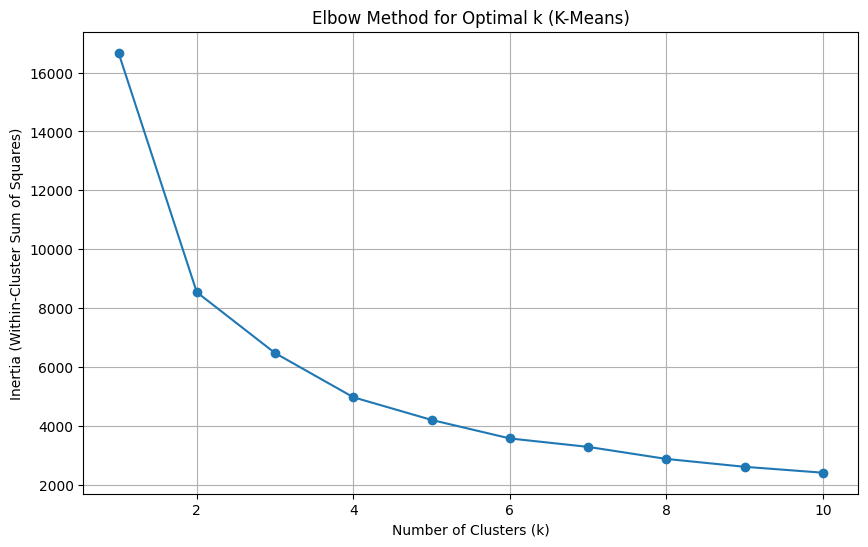

Plot generated. Please examine the graph to choose the optimal k.


In [ ]:

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np 


X = rfm_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values


inertia = []
k_range = range(1, 11) 

print("Calculating Inertia (Cost) for k=1 to 10 using KMeans...")

for k in k_range:

    kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42, max_iter=300)
    kmeans.fit(X)

    inertia.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k (K-Means)')
plt.grid(True)
plt.show()

print("Plot generated. Please examine the graph to choose the optimal k.")

In [ ]:

optimal_k = 4


print(f"Running final KMeans model with optimal k = {optimal_k}...")


X = rfm_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values


kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init='auto', random_state=42, max_iter=300)
kmeans.fit(X)
clusters = kmeans.predict(X)


rfm_df['Cluster'] = clusters
rfm_df['Cluster'] = rfm_df['Cluster'].astype(str) 

print("\nClustering complete. Cluster labels added to rfm_df.")
print(f"Cluster centroids (in log space):\n{kmeans.cluster_centers_}")
print(rfm_df.head())

Running final KMeans model with optimal k = 4...

Clustering complete. Cluster labels added to rfm_df.
Cluster centroids (in log space):
[[2.95851561 1.05869643 5.95730772]
 [4.1183947  1.53006866 7.28370042]
 [5.15634317 0.83423722 5.55038519]
 [2.05265807 2.33911751 8.21940108]]
  CustomerID  Recency  Frequency  Monetary  Monetary_log  Frequency_log  \
0    12346.0      326          1  77183.60     11.253955       0.693147   
1    12347.0        2          7   4310.00      8.368925       2.079442   
2    12348.0       75          4   1797.24      7.494564       1.609438   
3    12349.0       19          1   1757.55      7.472245       0.693147   
4    12350.0      310          1    334.40      5.815324       0.693147   

   Recency_log Cluster  
0     5.789960       1  
1     1.098612       3  
2     4.330733       1  
3     2.995732       1  
4     5.739793       2  


In [ ]:


segment_summary = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()


segment_size = rfm_df.groupby('Cluster').size().reset_index(name='Count')
segment_size['Percentage'] = (segment_size['Count'] / segment_size['Count'].sum()) * 100
segment_summary = pd.merge(segment_summary, segment_size, on='Cluster')


segment_summary['Monetary'] = segment_summary['Monetary'].map('${:,.2f}'.format)


segment_summary = segment_summary.sort_values(by='Count', ascending=False).reset_index(drop=True)

print("--- Customer Segment Summary (Mean Original RFM) ---")
print(segment_summary)

--- Customer Segment Summary (Mean Original RFM) ---
  Cluster     Recency  Frequency   Monetary  Count  Percentage
0       2  198.451117   1.386872    $319.78   1432   33.010604
1       1   75.296233   4.099315  $1,856.28   1168   26.924850
2       0   23.020148   2.068929    $468.32    943   21.738128
3       3    9.543396  12.335849  $7,350.61    795   18.326418


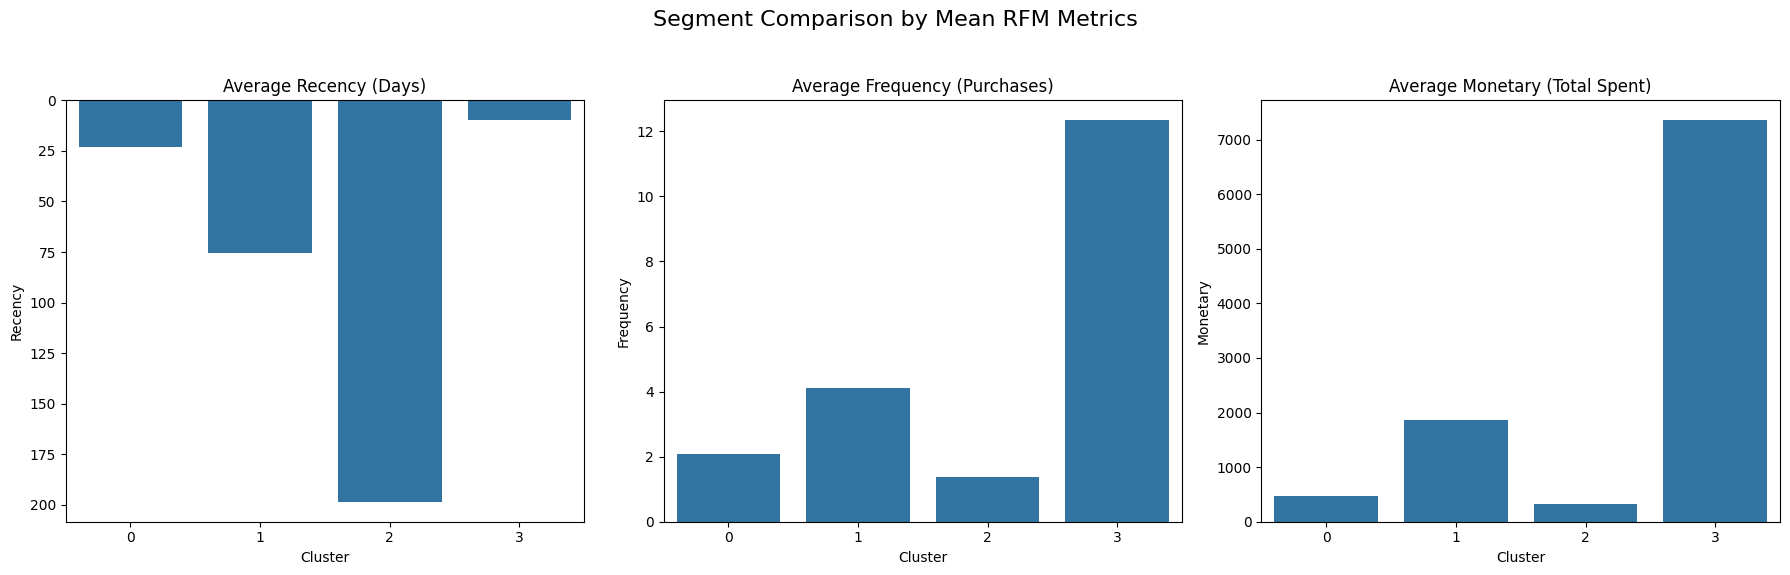

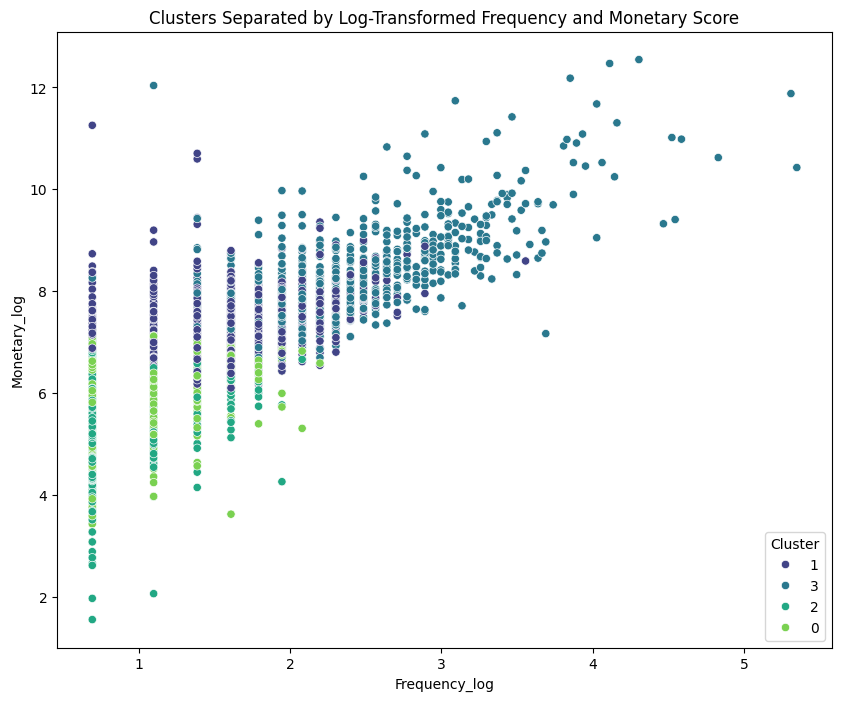

In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt

segment_summary_plot = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle('Segment Comparison by Mean RFM Metrics', fontsize=16)


sns.barplot(x='Cluster', y='Recency', data=segment_summary_plot, ax=axes[0])
axes[0].set_title('Average Recency (Days)')

axes[0].invert_yaxis() 


sns.barplot(x='Cluster', y='Frequency', data=segment_summary_plot, ax=axes[1])
axes[1].set_title('Average Frequency (Purchases)')


sns.barplot(x='Cluster', y='Monetary', data=segment_summary_plot, ax=axes[2])
axes[2].set_title('Average Monetary (Total Spent)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


plt.figure(figsize=(10, 8))

sns.scatterplot(x='Frequency_log', y='Monetary_log', hue='Cluster', data=rfm_df, palette='viridis')
plt.title('Clusters Separated by Log-Transformed Frequency and Monetary Score')
plt.show()

In [16]:
## 5. Key Findings & Actionable Business Recommendations

Based on the KMeans clustering of the RFM metrics, we have identified four distinct customer segments.

### 🏆 Segment 3: High-Value Champions (18.3% of Customer Base)
* **Characteristics:** These are your most profitable, loyal customers. They drive the most revenue and shop most frequently.
* **Recommendation:**
    1.  **Retention & Reward:** Offer VIP status, early access to new products, or exclusive event invitations. The goal is appreciation and loyalty locking.
    2.  **Referral Programs:** Encourage them to refer friends by offering significant rewards, leveraging their high satisfaction.

### 🌟 Segment 1: Loyal & Regular (26.9% of Customer Base)
* **Characteristics:** These customers are strong, reliable contributors to revenue and frequency. They are valuable but may not buy the absolute most expensive items.
* **Recommendation:**
    1.  **Value-Added Upselling:** Focus on personalized product recommendations (e.g., matching accessories or upgrades) to increase their Monetary value.
    2.  **Nurturing:** Use lifecycle emails with relevant content, not just discounts, to keep the brand top-of-mind.

### 🌱 Segment 0: New & Promising (21.7% of Customer Base)
* **Characteristics:** These are recently acquired customers who have made an initial purchase but haven't established high frequency yet. They represent future growth potential.
* **Recommendation:**
    1.  **Onboarding & Education:** Send a short, highly-engaging email series to educate them on the full product range and company value proposition.
    2.  **Incentivize Second Purchase:** Offer a small, time-sensitive incentive (e.g., 10% off next purchase) to drive their Frequency up quickly.

### 😴 Segment 2: Lapsed Customers (33.0% of Customer Base)
* **Characteristics:** This is the largest segment but contributes the least recent value. These customers are at risk of churning entirely.
* **Recommendation:**
    1.  **Win-Back Campaign:** Launch a targeted email/ad campaign with a strong, highly attractive offer (e.g., 20% off plus free shipping) to encourage a reactivation purchase.
    2.  **Survey for Feedback:** For those who don't respond to offers, send a short "We miss you" survey to understand why they left, gathering data for future improvements.

SyntaxError: unterminated string literal (detected at line 18) (1779499381.py, line 18)